# Social Networks and Text Analysis - Week 4: Network’s Partitions, Community detection

_Lecturer:_ Dr. Riccardo Di Clemente r.di-clemente@exeter.ac.uk
\
_Teaching assistant:_  Ben Dennes b.g.dennes@exeter.ac.uk

In [30]:
## Only run this if you are using Google Colab and need to install new packages 
# before you can use them
!pip install python-igraph
!pip install python-louvain

!pip install --upgrade scipy networkx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
## Now import the librares required for this lab
import networkx as nx #---> Library for network analysis
import matplotlib.pyplot as plt #---> Library for creating plots
import matplotlib.colors as mcolors #---> Library for adding colours to plots
import collections #---> Library for operating with dictionaries
import random #---> Library for generating random numbers/distributions
# import community #---> Library for performing community detection
from community import community_louvain
import numpy as np #---> Library for efficiently operating with arrays/matrices/vectors
import igraph #---> Additional library for network analysis
%matplotlib inline

# 1a) Plotting function

In [32]:
def draw_clu(G, pos, community_labels, community_alg_name):
    # community_labels must be a dictionary of node community labels, indexed by node id

    # find the unique community labels
    clusters = np.array(list(set(community_labels.values())))

    # Create the plot of the network to be placed in the figure
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, 
                                   cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), # colour map to be used for plotting the communities
                                   node_color=list(community_labels.values()),
                                   nodelist=list(community_labels.keys())) # list of nodes to plot (here, this is all the nodes that are assigned a community)

    # Add labels to the plot
    labels = nx.draw_networkx_labels(G, pos, font_size=9)

    # Add edges to the plot
    edges = nx.draw_networkx_edges(G, pos, alpha=0.5)

    # set the plot as the name of the community detection algorithm
    plt.title(community_alg_name)

    # Add a colour bar to act as a legend
    cb = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Communities')
    cb.ax.tick_params(length=0)
    # Adds the community labels to the colour bar
    cb.set_ticklabels(list(set(community_labels.values())))

    nodes.set_clim(-0.5, len(clusters)-0.5)

    # Show the plot without the x/y axis
    plt.axis('off')
    plt.show()

## Louvain Algorithm

In [33]:
# Get the karate club network datast from the networkx library
G = nx.karate_club_graph()

# Set the positions of the nodes according to a spring layout
pos = nx.spring_layout(G)

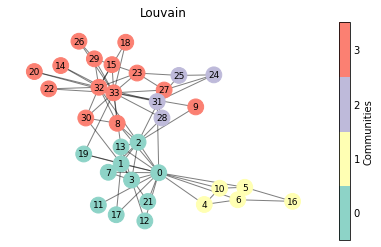

In [34]:
# perform community detection on the karate club network using the Louvain algorithm (the default for networkx)
community_labels_louvain = community_louvain.best_partition(G)

# Run the function and draw the network
plt.figure(figsize=(7,4))
draw_clu(G, pos, community_labels_louvain, 'Louvain')

## Convert networkx to igraph

igraph is an alternative python package to networkx - information and documentation can be found [here](https://igraph.org/python/versions/latest/)

In [35]:
# Gn = nx.path_graph(4) # Create a random NX graph
nx.write_graphml(G, 'graph.graphml') # Export NX graph to file

import igraph as ig
Gi = ig.read('graph.graphml',format="graphml") # Create new IG graph from the same file

## Infomap Algorithm

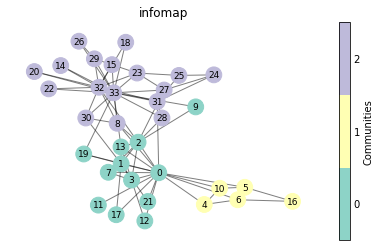

In [40]:
# Use igraph to detect communities with the infomap algorithm
community_labels_list = Gi.community_infomap().membership

# make a dictionary of each node's community membership for the graph
community_labels_infomap = dict(zip(range(len(community_labels_list)), community_labels_list))

# Plot the graph using the same function
plt.figure(figsize=(7,4))
draw_clu(G, pos, community_labels_infomap, 'infomap')

## Newman's eigenvector method

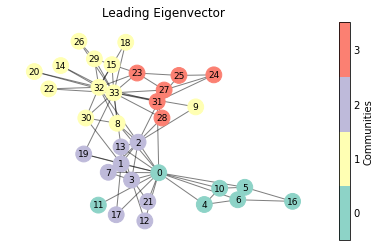

In [41]:
# Use igraph to detect communities with Newman's eigenvector method
community_labels_list = Gi.community_leading_eigenvector().membership

# make a dictionary of each node's community membership for the graph
community_labels_newman = dict(zip(range(len(community_labels_list)), community_labels_list))

# Plot the graph using the same function
plt.figure(figsize=(7,4))
draw_clu(G, pos, community_labels_newman, 'Leading Eigenvector' )

## Walking trap algorithm

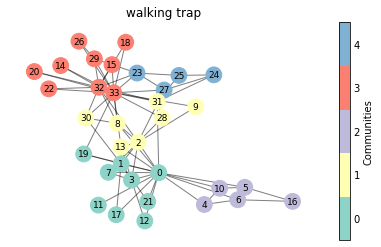

In [42]:
# Use igraph to detect communities with the walking trap algorithm
community_labels_list = Gi.community_walktrap().as_clustering().membership

# make a dictionary of each node's community membership for the graph
community_labels_wt = dict(zip(range(len(community_labels_list)), community_labels_list))

# Plot the graph using the same function
plt.figure(figsize=(7,4))
draw_clu(G, pos, community_labels_wt,'walking trap' )

# 1b) Comparing community assignments

Communitiy assignments can be compared using the Rand Index, a method also used in machine learning to evaluate clustering performance or measure consensus between different cluster assignments.

Given two lists of labels (in this case, community assignments) the Rand Index "measures the similarity of the two assignments, ignoring permutations" [[sklearn docs](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)]]

In [43]:
from sklearn import metrics

# create a list of the different community assignments
all_cluster_labels = [
    list(community_labels_louvain.values()),
    list(community_labels_infomap.values()),
    list(community_labels_newman.values()),
    list(community_labels_wt.values())
]

alg_names = [
    'Louvain',
    'Infomap',
    'Newman',
    'Walking trap'
]

n = len(all_cluster_labels) # number of clustering algorithms

# create a square array of NaN values - this will be filled with the assignments' similarity scores
scores = np.empty((n,n))
scores[:] = np.nan

# loop through the upper triangular elements of the array
for i in range(n):
    for j in range(i+1,n):
        a = all_cluster_labels[i]
        b = all_cluster_labels[j]
        
        score = metrics.rand_score(a,b)
        scores[i,j] = score

        print(f'{alg_names[i]} & {alg_names[j]}: {np.around(score, 3)}')

Louvain & Infomap: 0.865
Louvain & Newman: 0.893
Louvain & Walking trap: 0.834
Infomap & Newman: 0.793
Infomap & Walking trap: 0.774
Newman & Walking trap: 0.841


# Example of clustering for similarity networks

In [ ]:
from collections import Counter, defaultdict #---> Library for operating with dictionaries
import operator #---> Library for doing maths
import seaborn as sns #---> Library for drawing plots
from matplotlib import pyplot, patches #---> Library for drawing plots

Below is a toy example of generating a similarity network. We generate a list of users, each assigned some random items: 'codes' (strings). These codes could represent films the users have watched, or books they own, or items they commonly buy online.

We can compare users based on shared entries in their codes to generate a metric between 0 and 1 for each pair of users of their 'similarity'. We then identify 'similar' users using a threshold on this metric. 

This then transforms into a network problem - we connect users who are similar (i.e. those with sufficiently similar entries in their codes). Once we have a network we can then apply algorithms like community detection and centrality analysis.

In [44]:
# Creation of the random sample of users
nuser = 100
max_codes = 20 # the maximum number of codes per user
codes = [str(x) for x in range(max_codes+1)] # the codes available for each user

user_codes = []

# For each user, create a set of codes
for k in range(nuser):
    user_n_codes = random.randint(1, max_codes) # randomly decide the length of the code for the user
    user_codes.append(random.sample(codes, user_n_codes)) # sample user_n_codes strings from the 'codes' list

In [ ]:
user_codes

In [46]:
#similarity network generation using the jaccard relation https://en.wikipedia.org/wiki/Jaccard_index

# Initialise empty lists to fill with values
edges = []
weights = []

# For each user, look at the number of shared code entries with other users
for k in range(nuser):
    for k2 in range(k+1,nuser):
        intersection = len(set(user_codes[k]).intersection(user_codes[k2])) # the intersection of the two users' codes - the number of shared entries
        union = len(set(user_codes[k]+user_codes[k2])) # the combined total unique entries for the two users
        similarity = float(abs(intersection))/float(union) # Jaccard similarity is defined as the number of shared entries divided by the total unique entries

        edges.append((k,k2))
        weights.append(similarity)

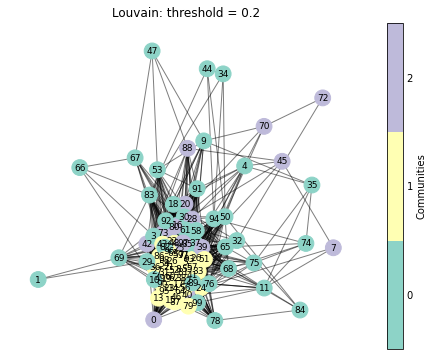

100 nodes
2610 edges


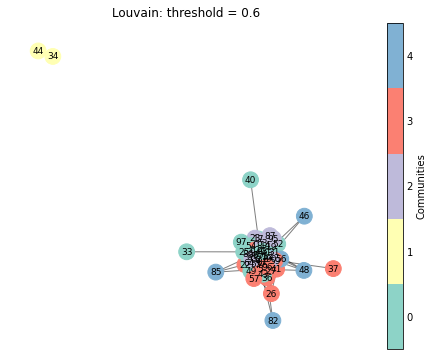

50 nodes
617 edges


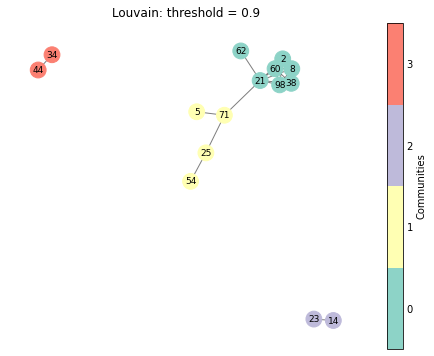

15 nodes
22 edges


In [49]:
thresholds = [0.2, 0.6, 0.9]

for t in thresholds:
    # Create a graph
    G_per = nx.Graph()

    for (a,b), similarity in zip(edges, weights):
        if similarity > t:
            G_per.add_edge(a, b, weight=similarity)

    # Now plot the graph again using a a different method
    plt.figure(figsize=(8,6))
    draw_clu(G_per, nx.spring_layout(G_per), community_louvain.best_partition(G_per), f'Louvain: threshold = {t}')
    print(len(G_per.nodes()), 'nodes')
    print(len(G_per.edges()), 'edges')

# Dendrogram

## Basic string representation

In [ ]:
#generic string visualization of Dendogram plot using louvain in community package
G = nx.karate_club_graph()

print(community_louvain.best_partition(G)) 

# Create and store the dendogram, then print it
dendrogram = community_louvain.generate_dendrogram(G)
print(community_louvain.partition_at_level(dendrogram, 0)) 
print(community_louvain.partition_at_level(dendrogram, 1)) 

{0: 0, 1: 0, 2: 0, 3: 0, 4: 2, 5: 2, 6: 2, 7: 0, 8: 1, 9: 1, 10: 2, 11: 0, 12: 0, 13: 0, 14: 1, 15: 1, 16: 2, 17: 0, 18: 1, 19: 0, 20: 1, 21: 0, 22: 1, 23: 3, 24: 3, 25: 3, 26: 1, 27: 3, 28: 3, 29: 1, 30: 1, 31: 3, 32: 1, 33: 1}
{0: 1, 1: 1, 2: 1, 3: 1, 4: 4, 5: 2, 6: 2, 7: 1, 8: 3, 9: 0, 10: 4, 11: 1, 12: 1, 13: 1, 14: 0, 15: 0, 16: 2, 17: 1, 18: 0, 19: 1, 20: 0, 21: 1, 22: 0, 23: 0, 24: 5, 25: 5, 26: 0, 27: 0, 28: 5, 29: 0, 30: 3, 31: 5, 32: 0, 33: 0}
{0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 0, 8: 2, 9: 2, 10: 1, 11: 0, 12: 0, 13: 0, 14: 2, 15: 2, 16: 1, 17: 0, 18: 2, 19: 0, 20: 2, 21: 0, 22: 2, 23: 2, 24: 3, 25: 3, 26: 2, 27: 2, 28: 3, 29: 2, 30: 2, 31: 3, 32: 2, 33: 2}


## Plot a dendrogram

Girvan-Newman algorithm results in a dendrogram. Each iteration, an edge is removed (with the highest betweenness). This means each iteration the network is split up into different communities

### Code

Skip this part to just see the dendrogram plot

In [50]:
from itertools import chain, combinations #---> Library to improve iterables
from scipy.cluster.hierarchy import dendrogram #---> Library for computing dendrograms

# Get simulated Graph() and Girvan-Newman communities list, we can use either the similarity graph or the karate club graph

# By default we will use the karate club graph, uncomment the second line to use the similarity graph
G = nx.karate_club_graph()
#G=G_per

communities = list(nx.community.girvan_newman(G))

The below shows the node segmentation at each step of the algorithm

In [51]:
print(communities[0])
print(communities[1])
print('...')
print(communities[-2])
print(communities[-1])

({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {2, 8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33})
({0, 1, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21}, {32, 33, 2, 8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}, {9})
...
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32, 33})
({0}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}, {21}, {22}, {23}, {24}, {25}, {26}, {27}, {28}, {29}, {30}, {31}, {32}, {33})


here we assign each possible subset shown in the above steps a unique id

(we aim eventually to generate a dendrogram graph, so we describe these subsets as nodes)

In [52]:
# building initial dict of node_id to each possible subset:
node_id = 0 # node here is an arbitrary id for a possible subset
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])} # start with the most fundamental subset - the entire network - label it node_id=0

for comm in communities: # iterate through each step of the GN algo
    for subset in list(comm): # for each community at that step
        if subset not in init_node2community_dict.values(): # if that community (subset) is new in the dendrogram
            node_id += 1 # increase the arbitrary node id...
            init_node2community_dict[node_id] = subset # ...and add the new subset to the running collection

In [53]:
# turning this dictionary to the desired format
node_id_to_children = {e: [] for e in init_node2community_dict.keys()} # for every subset id, initialize an empty list

for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2): # for each pair combination of subset ids (potential children)
    for node_id_parent, group in init_node2community_dict.items(): # for each possible subset (id and subset of network nodes) - (potential parent)
        
        # check two conditions - if both are met, node_id_parent is the parent of node_id1 and node_id2

        # 1. no overlap between the two subsets labelled node_id1 and node_id2 (they are distinct)
        cond1 = len( init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2]) ) == 0

        # 2. the chosen subset (the loop variable 'group') is formed exactly from the union of the two subsets node_id1 and node_id2, i.e. is the parent
        cond2 = group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2])

        if cond1 and cond2:
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# node_id_to_children is now a dictionary of each parent and child subsets (vertices on the dendrogram)

In [54]:
# also recording node_labels dict for the correct label for dendrogram leaves
# i.e. map the dendrogram leaf node id to the underlying network's nodes
node_labels = dict()
for node_id, group in init_node2community_dict.items(): # for each possible subset
    if len(group) == 1: # if a leaf node (i.e. a single element subset)
        node_labels[node_id] = list(group)[0] # the contained element in that node is given as the node label
    else:
        node_labels[node_id] = '' # no label for non-leaf nodes

In [55]:
# also need a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]: # run through GN algo results in reverse
    for p in list(e): # for each subset at that algo step
        if tuple(p) not in subset_rank_dict: # if that subset hasn't been recorded yet, record it and increase the rank 
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank # add the final subset - all the elements

In [56]:
# function to get a merge height so that it is unique (to plot each merge at a different height)
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

In [57]:
# transform dictionary of parents and children to dendrogram graph in networkx
G = nx.DiGraph(node_id_to_children) # make directed graph from parent-children dictionary
nodes = G.nodes()
leaves = set( n for n in nodes if G.out_degree(n) == 0 ) # leaf nodes by definition have no children (so zero out-degree)
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ] # non-leaf nodes by definition have at least one child node(non-zero out-degree)

# nx.draw(G)

In [58]:
# Compute the size of each subtree

# the subtree of each leaf node is simply that leaf node itself
subtree = dict( (n, [n]) for n in leaves )

for u in inner_nodes: # for each non-leaf (inner) node
    children = set()
    node_list = list(node_id_to_children[u]) # get the ids of the children of the node

    # find the children of the node, and their children, and *their* children, etc. until the entire subtree from u to the leaves is identified
    while len(node_list) > 0:
        v = node_list.pop(0) # take the first element of node_list and remove it simultaneously
        children.add(v) # add that child node to the running set
        node_list += node_id_to_children[v] # add the children of that node to the node_list
        
    subtree[u] = sorted(children & leaves) # take only the children that are leaf nodes - these leaf nodes define the size of the subtree

In [59]:
inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

In [60]:
# Construct the linkage matrix
leaves = sorted(leaves)
index = {tuple([n]) : i for i, n in enumerate(leaves)} # creates a dictionary with leaf node id tuple as key and arbitrary index as value
Z = [] # initialize empty list for linkage matrix
k = len(leaves) # the next index value

for i, n in enumerate(inner_nodes): # for each inner node - because of sorting, this starts at the nodes with leaf nodes as children
    children = node_id_to_children[n] # get the immediate children of the node
    x = children[0] # make x the first child node id
    for y in children[1:]: # for each of the remaining child node ids
        z = tuple(sorted(subtree[x] + subtree[y])) # get a sorted tuple of all the leaf nodes in the subtrees of x and y
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))] # gets the indices of these two subtrees
        
        # add entry to the 'linkage matrix'
        # subtree indices, merge height of the inner node in question (n), and the size of the subtree (no. leaf nodes)
        # these are so the plot function knows where to put the branching
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k # adds an entry for the combined subtrees of nodes x and y
        subtree[z] = list(z) # and an entry in the subtrees dict
        x = z
        k += 1

In [ ]:
Z

### The Dendrogram Plot!

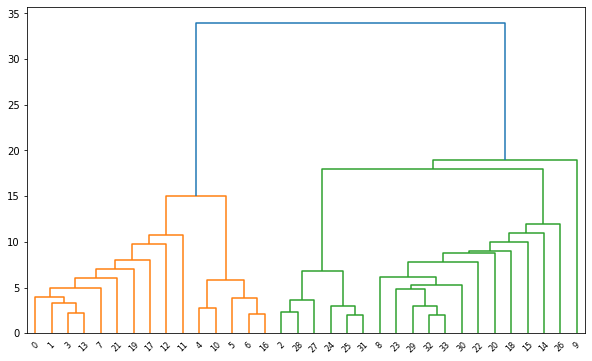

In [62]:
# Create a figure to plot the dendrogram
fig, ax = plt.subplots(figsize=(10,6))

# "Catch" the call with a variable assignment so the output is shown properly
dend = dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves], ax=ax)